In [2]:
import os
import gc
import sys
import pdb
import copy
import glob
import psutil
import imageio
import calendar
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib as mpl
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from memory_profiler import memory_usage
from matplotlib.patches import Rectangle
from cftime import DatetimeNoLeap as date
from matplotlib.colors import TwoSlopeNorm
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 14,   # Axis labels
    'xtick.labelsize' : 12,   # X-axis tick labels
    'ytick.labelsize' : 12,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()
#mpl.use('Agg')
#%matplotlib agg

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)
fix_dtint   = putil.adjust_10daily_integrated_tendency
shift_dtint = putil.shift_integrated_tendency
sig         = putil.filter_significance
cmn         = putil.get_cmap_norm

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/wavePaperFigs/util')
import nclcmaps as ncm

In [3]:
importlib.reload(putil)
importlib.reload(ces)
from IPython.display import clear_output

# ----- get data
kwargs = {'freq':'10daily', 'return_intersection':False, 'return_members':True, 'skip_nosrctag':True}
u_           = putil.get_variable('U', **kwargs)
clear_output()

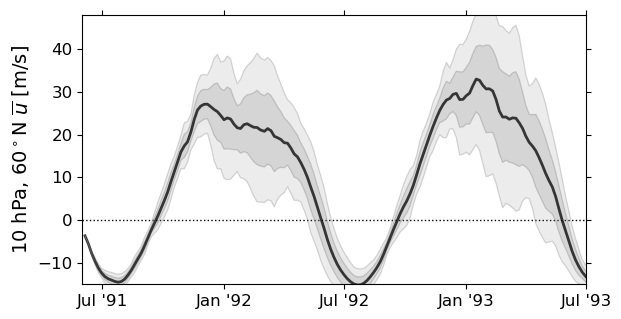

In [10]:
importlib.reload(putil)
importlib.reload(ces)

# --- make figure
fig = plt.figure(figsize=(6.5,3.5))
ax = fig.add_subplot(111)

# ---- get dims and data
pvilat, pvip = 40, 10
plev = u_['cfmean'].plev
time = u_['cfmean'].time
time = putil.to_datetime(time)
N = len(u_['members'].ens)

# ----- plotting settings
topt = {'option':'solstice', 'include_year':True}
tlim = [datetime(1991,6,1),datetime(1993,7,1)]

# --- get data
u_pvi     = u_['cfmean'].sel(lat=pvilat, plev=pvip, method='nearest')
u_mem_pvi = u_['cf_members'].sel(lat=pvilat, plev=pvip, method='nearest')
mems_mean = u_mem_pvi.mean('ens')
mems_std  = u_mem_pvi.std('ens')

# ---- get confidence intervals
ci = putil.confidence_interval(mems_mean, mems_std, N, 0.05) 
    
# ----- plot winds at 10 hPa
ax.plot(time, mems_mean, '-', color='k', lw=2, alpha=0.75, label='ensemble mean')
if(1):
    ax.fill_between(time, y1=mems_mean-mems_std, y2=mems_mean+mems_std, color='grey', alpha=0.2, label='ensemble std')
    ax.fill_between(time, y1=mems_mean-mems_std*2, y2=mems_mean+mems_std*2, color='grey', alpha=0.15, label='ensemble std')
    ax.plot(time, mems_mean-mems_std, '-', color='grey', alpha=0.2, lw=0.7)
    ax.plot(time, mems_mean+mems_std, '-', color='grey', alpha=0.2, lw=0.7)
    ax.plot(time, mems_mean-mems_std*2, '-', color='grey', alpha=0.2, lw=0.7)
    ax.plot(time, mems_mean+mems_std*2, '-', color='grey', alpha=0.2, lw=0.7)
ax.axhline(y=0, ls=':', color='k', lw=1, zorder=0)

#ax2.yaxis.set_ticks([-15, -10, -5, 0, 5, 10, 15])
ax.set_xlim(tlim)
ax.set_ylim([-15, 48])
putil.season_timeticks(ax, time, **topt)
putil.format_ticks(ax)
ax.set_ylabel('10 hPa, 60$^\\circ$N $\\overline{{u}}$ [m/s]')

#legend = ax.legend(loc='lower right', fancybox=False, edgecolor='k', framealpha=1, ncol=3, frameon=False, fontsize=11)
#legend.get_frame().set_linewidth(0.66)

plt.savefig('figs/pvi_spread.pdf', dpi=200)
plt.show()

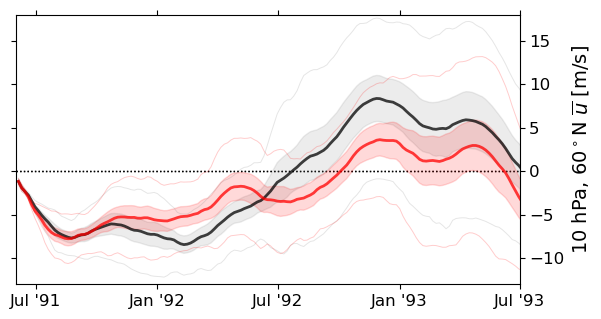

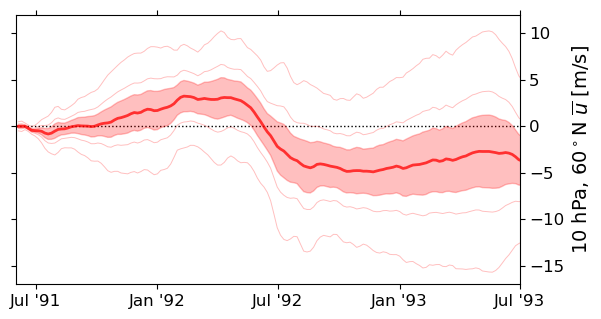

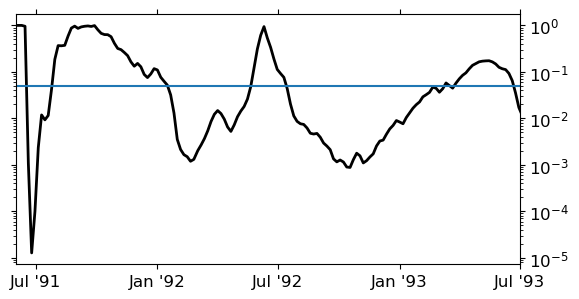

In [53]:
importlib.reload(putil)
importlib.reload(ces)

# --- make figure
fig = plt.figure(figsize=(6.5,3.5))
ax = fig.add_subplot(111)

# ---- get dims and data
pvilat, pvip = 0, 30
plev = u_['cfmean'].plev
time = u_['cfmean'].time
time = putil.to_datetime(time)

# ----- plotting settings
topt = {'option':'solstice', 'include_year':True}
tlim = [datetime(1991,6,1),datetime(1993,7,1)]
cf_mean_color = 'k'
cf_std_color = 'grey'
mean_color = 'r'
std_color = 'r'

N = len(u_['members'].ens)

# --- get counterfactual data
u_pvi     = u_['cfmean'].sel(lat=pvilat, plev=pvip, method='nearest')
u_mem_pvi = u_['cf_members'].sel(lat=pvilat, plev=pvip, method='nearest')
mems_mean = u_mem_pvi.mean('ens')
mems_std  = u_mem_pvi.std('ens')

# ---- get confidence intervals
ci = putil.confidence_interval(mems_mean, mems_std, N, 0.05) 
    
# ----- plot counterfactual winds at 10 hPa
ax.plot(time, mems_mean, '-', color=cf_mean_color, lw=2, alpha=0.75, label='ensemble mean')
if(1):
    ax.fill_between(time, y1=ci[0], y2=ci[1], color=cf_std_color, alpha=0.15, label='ensemble CI')
    ax.plot(time, mems_mean-mems_std*2.11, '-', color=cf_std_color, alpha=0.2, lw=0.7)
    ax.plot(time, mems_mean+mems_std*2.11, '-', color=cf_std_color, alpha=0.2, lw=0.7)
    ax.axhline(y=0, ls=':', color='k', lw=1, zorder=0)


# --- get data
u_pvi     = u_['ensmean'].sel(lat=pvilat, plev=pvip, method='nearest')
u_mem_pvi = u_['members'].sel(lat=pvilat, plev=pvip, method='nearest')
mems_mean = u_mem_pvi.mean('ens')
mems_std  = u_mem_pvi.std('ens')

# ---- get confidence intervals
ci = putil.confidence_interval(mems_mean, mems_std, N, 0.05)

# ----- plot forced winds at 10 hPa
for i in range(len(u_mem_pvi.ens)):
    mem = u_mem_pvi.isel(ens=i)
    label = [None, 'ensemble members'][i==0]
    #ax.plot(time, mem, '-', color='k', lw=1.2, alpha=0.15, label=label)
ax.plot(time, mems_mean, '-', color=mean_color, lw=2, alpha=0.75, label='ensemble mean')
if(1):
    ax.fill_between(time, y1=ci[0], y2=ci[1], color=std_color, alpha=0.15, label='ensemble CI')
    ax.plot(time, mems_mean-mems_std*2.11, '-', color=std_color, alpha=0.2, lw=0.7)
    ax.plot(time, mems_mean+mems_std*2.11, '-', color=std_color, alpha=0.2, lw=0.7)
    ax.axhline(y=0, ls=':', color='k', lw=1, zorder=0)

#ax2.yaxis.set_ticks([-15, -10, -5, 0, 5, 10, 15])
ax.set_xlim(tlim)
ax.set_ylim([-13, 18])
putil.season_timeticks(ax, time, **topt)
putil.format_ticks(ax)
ax.set_ylabel('10 hPa, 60$^\\circ$N $\\overline{{u}}$ [m/s]')
putil.format_ticks(ax, y='right')



# ================= impact

# --- make figure
fig = plt.figure(figsize=(6.5,3.5))
ax = fig.add_subplot(111)

# ---- get dims and data
plev = u_['cfmean'].plev
time = u_['cfmean'].time
time = putil.to_datetime(time)

# ----- plotting settings
topt = {'option':'solstice', 'include_year':True}
tlim = [datetime(1991,6,1),datetime(1993,7,1)]
cf_mean_color = 'k'
cf_std_color = 'grey'
mean_color = 'r'
std_color = 'r'

# --- get counterfactual data
p_pvi     = u_['pval'].sel(lat=pvilat, plev=pvip, method='nearest')
u_pvi     = u_['impact'].sel(lat=pvilat, plev=pvip, method='nearest')
u_mem_pvi = (u_['members']-u_['cf_members']).sel(lat=pvilat, plev=pvip, method='nearest')
mems_mean = u_mem_pvi.mean('ens')
mems_std  = u_mem_pvi.std('ens')

# ---- get confidence intervals
ci = putil.confidence_interval(mems_mean, mems_std, N, 0.05) 
    
# ----- plot counterfactual winds at 10 hPa
ax.plot(time, mems_mean, '-', color=mean_color, lw=2, alpha=0.75, label='ensemble mean')
if(1):
    ax.fill_between(time, y1=ci[0], y2=ci[1], color=std_color, alpha=0.25, label='ensemble CI')
    for sf in [1,2]:
        ax.plot(time, mems_mean-mems_std*sf, '-', color=std_color, alpha=0.25, lw=0.7)
        ax.plot(time, mems_mean+mems_std*sf, '-', color=std_color, alpha=0.25, lw=0.7)
    ax.axhline(y=0, ls=':', color='k', lw=1, zorder=0)
    
    
ax.set_xlim(tlim)
ax.set_ylim([-17, 12])
putil.season_timeticks(ax, time, **topt)
putil.format_ticks(ax)
ax.set_ylabel('10 hPa, 60$^\\circ$N $\\overline{{u}}$ [m/s]')
putil.format_ticks(ax, y='right')


fig=plt.figure(figsize=(fig.get_size_inches()[0],fig.get_size_inches()[0]/2))
ax=fig.add_subplot(111)
ax.plot(time, p_pvi, '-', color=cf_mean_color, lw=2)
ax.set_yscale('log')
putil.season_timeticks(ax, time, **topt)
ax.set_xlim(tlim)
ax.axhline(y=0.05)
putil.format_ticks(ax, y='right')

plt.show()

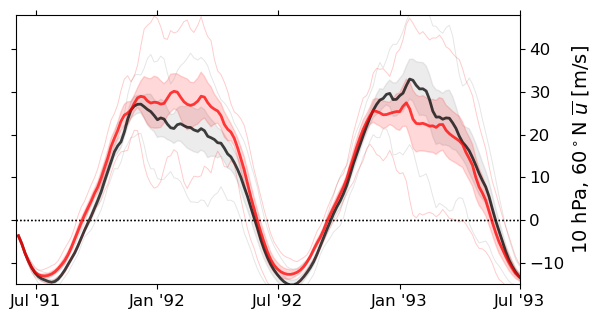

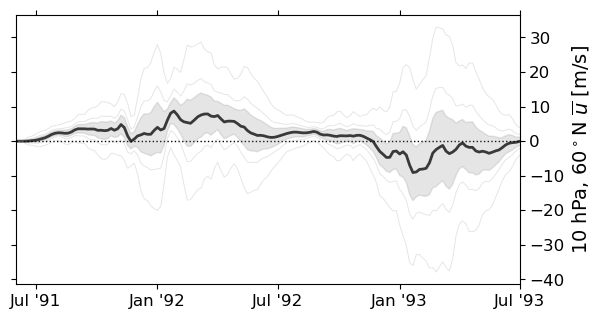

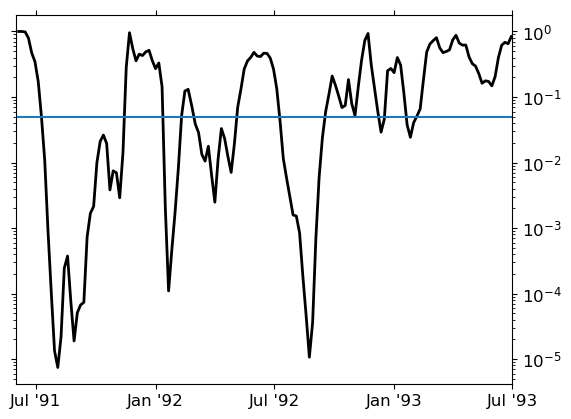

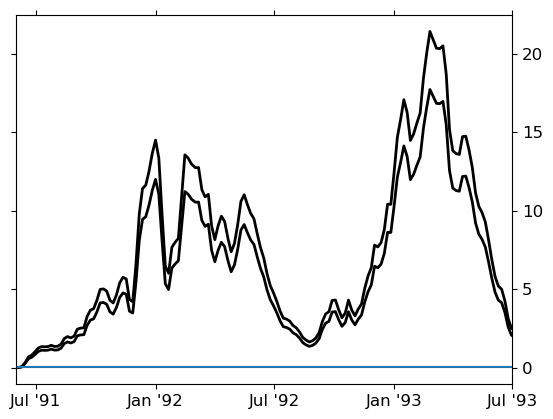

In [57]:
importlib.reload(putil)
importlib.reload(ces)

# --- make figure
fig = plt.figure(figsize=(6.5,3.5))
ax = fig.add_subplot(111)

# ---- get dims and data
pvilat, pvip = 40, 10
plev = u_['cfmean'].plev
time = u_['cfmean'].time
time = putil.to_datetime(time)

# ----- plotting settings
topt = {'option':'solstice', 'include_year':True}
tlim = [datetime(1991,6,1),datetime(1993,7,1)]
cf_mean_color = 'k'
cf_std_color = 'grey'
mean_color = 'r'
std_color = 'r'

# --- get counterfactual data
u_pvi     = u_['cfmean'].sel(lat=pvilat, plev=pvip, method='nearest')
u_mem_pvi = u_['cf_members'].sel(lat=pvilat, plev=pvip, method='nearest')
mems_mean = u_mem_pvi.mean('ens')
mems_std  = u_mem_pvi.std('ens')

# ---- get confidence intervals
ci = putil.confidence_interval(mems_mean, mems_std, N, 0.05) 
    
# ----- plot counterfactual winds at 10 hPa
ax.plot(time, mems_mean, '-', color=cf_mean_color, lw=2, alpha=0.75, label='ensemble mean')
if(1):
    ax.fill_between(time, y1=ci[0], y2=ci[1], color=cf_std_color, alpha=0.15, label='ensemble CI')
    ax.plot(time, mems_mean-mems_std*2, '-', color=cf_std_color, alpha=0.2, lw=0.7)
    ax.plot(time, mems_mean+mems_std*2, '-', color=cf_std_color, alpha=0.2, lw=0.7)
    ax.axhline(y=0, ls=':', color='k', lw=1, zorder=0)


# --- get data
u_pvi     = u_['ensmean'].sel(lat=pvilat, plev=pvip, method='nearest')
u_mem_pvi = u_['members'].sel(lat=pvilat, plev=pvip, method='nearest')
mems_mean = u_mem_pvi.mean('ens')
mems_std  = u_mem_pvi.std('ens')

# ---- get confidence intervals
ci = putil.confidence_interval(mems_mean, mems_std, N, 0.05) 

# ----- plot forced winds at 10 hPa
for i in range(len(u_mem_pvi.ens)):
    mem = u_mem_pvi.isel(ens=i)
    label = [None, 'ensemble members'][i==0]
    #ax.plot(time, mem, '-', color='k', lw=1.2, alpha=0.15, label=label)
ax.plot(time, mems_mean, '-', color=mean_color, lw=2, alpha=0.75, label='ensemble mean')
if(1):
    ax.fill_between(time, y1=ci[0], y2=ci[1], color=std_color, alpha=0.15, label='ensemble CI')
    ax.plot(time, mems_mean-mems_std*2, '-', color=std_color, alpha=0.2, lw=0.7)
    ax.plot(time, mems_mean+mems_std*2, '-', color=std_color, alpha=0.2, lw=0.7)
    ax.axhline(y=0, ls=':', color='k', lw=1, zorder=0)

#ax2.yaxis.set_ticks([-15, -10, -5, 0, 5, 10, 15])
ax.set_xlim(tlim)
ax.set_ylim([-15, 48])
putil.season_timeticks(ax, time, **topt)
putil.format_ticks(ax)
ax.set_ylabel('10 hPa, 60$^\\circ$N $\\overline{{u}}$ [m/s]')
putil.format_ticks(ax, y='right')



# ================= impact

# --- make figure
fig = plt.figure(figsize=(6.5,3.5))
ax = fig.add_subplot(111)

# ---- get dims and data
plev = u_['cfmean'].plev
time = u_['cfmean'].time
time = putil.to_datetime(time)

# ----- plotting settings
topt = {'option':'solstice', 'include_year':True}
tlim = [datetime(1991,6,1),datetime(1993,7,1)]
cf_mean_color = 'k'
cf_std_color = 'grey'
mean_color = 'r'
std_color = 'r'

# --- get impact data
p_pvi     = u_['pval'].sel(lat=pvilat, plev=pvip, method='nearest')
u_pvi     = u_['impact'].sel(lat=pvilat, plev=pvip, method='nearest')
u_mem_pvi = (u_['members']-u_['cf_members']).sel(lat=pvilat, plev=pvip, method='nearest')
mems_mean = u_mem_pvi.mean('ens')
mems_std  = u_mem_pvi.std('ens')

# ---- get confidence intervals
ci = putil.confidence_interval(mems_mean, mems_std, N, 0.05) 
    
# ----- plot impact winds at 10 hPa
ax.plot(time, mems_mean, '-', color=cf_mean_color, lw=2, alpha=0.75, label='ensemble mean')
if(1):
    #ax.fill_between(time, y1=mems_mean-mems_std*2.11, y2=mems_mean+mems_std*2.11, color=cf_std_color, alpha=0.15, label='ensemble std')
    ax.fill_between(time, y1=ci[0], y2=ci[1], color=cf_std_color, alpha=0.2, label='ensemble CI')
    for sf in [1,2]:
        ax.plot(time, mems_mean-mems_std*sf, '-', color=cf_std_color, alpha=0.2, lw=0.7)
        ax.plot(time, mems_mean+mems_std*sf, '-', color=cf_std_color, alpha=0.2, lw=0.7)
    ax.axhline(y=0, ls=':', color='k', lw=1, zorder=0)
    
ax.set_xlim(tlim)
#ax.set_ylim([-5, 5])
putil.season_timeticks(ax, time, **topt)
putil.format_ticks(ax)
ax.set_ylabel('10 hPa, 60$^\\circ$N $\\overline{{u}}$ [m/s]')
putil.format_ticks(ax, y='right')

fig=plt.figure()
ax =fig.add_subplot(111) 
ax.plot(time, p_pvi, '-', color=cf_mean_color, lw=2)
ax.set_yscale('log')
putil.season_timeticks(ax, time, **topt)
ax.set_xlim(tlim)
ax.axhline(y=0.05)
putil.format_ticks(ax, y='right')

fig=plt.figure()
ax =fig.add_subplot(111) 
ax.plot(time, mems_std, '-', color=cf_mean_color, lw=2)
ax.plot(time, ci[1]-ci[0], '-', color=cf_mean_color, lw=2)
putil.season_timeticks(ax, time, **topt)
ax.set_xlim(tlim)
ax.axhline(y=0.05)
putil.format_ticks(ax, y='right')

plt.show()